# Energy Consumption
To better follow the energy consumption, the government wants energy suppliers to install smart meters in every home in England, Wales and Scotland. There are more than 26 million homes for the energy suppliers to get to, with the goal of every home having a smart meter by 2020.

This roll out of meter is lead by the European Union who asked all member governments to look at smart meters as part of measures to upgrade our energy supply and tackle climate change. After an initial study, the British government decided to adopt smart meters as part of their plan to update our ageing energy system.

In this dataset, you will find a refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. The data from the smart meters seems associated only to the electrical consumption.

**Approach : **

1.  Combine all blocks into a single dataframe- keeping on relevant columns.
2. Use day-level energy consumption data per household to normalize data for inconsistent household count
3. Explore relationships between weather conditions and energy consumptions. Create clusters for the weather data- using which we can add weather identifiers to day-level data
4. Add UK holidays data to the day level data as an indicator.
5. Fit an ARIMA model
        i) ACF, PACF
        ii) Explore Seasonal Decomposition
        iii) Modelling 
7. Fit an LSTM model

# Daily Energy Data Preparation

**Importing Libraries **

In [ ]:
#!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
# import pyflux as pf  # PyFlux is deprecated, we'll use statsmodels instead
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Energy Data

> We are predicting for energy demand in the future- therefore we are taking only energy sum i.e. total energy use per day for a given household.

In [ ]:
# Combining all blocks
# temp_files klasörünü oluştur
import os
if not os.path.exists("temp_files"):
    os.makedirs("temp_files")

print("Combining all block files...")
for num in range(0,112):
    df = pd.read_csv("dataset/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv(f"temp_files/hc_{num}.csv")
    if num % 20 == 0:
        print(f"Processed block {num}/111")

fout= open("energy.csv","a")
# first file:
for line in open("temp_files/hc_0.csv"):
    fout.write(line)
# now the rest:    
for num in range(1,112):
    f = open(f"temp_files/hc_{num}.csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()
print("All blocks combined into energy.csv")
print("Temporary files saved to temp_files/ directory")

Combining all block files...
Processed block 0/111
Processed block 20/111
Processed block 20/111
Processed block 40/111
Processed block 40/111
Processed block 60/111
Processed block 60/111
Processed block 80/111
Processed block 80/111
Processed block 100/111
Processed block 100/111
All blocks combined into energy.csv
All blocks combined into energy.csv


** Energy at Day Level **

In [6]:
energy = pd.read_csv('energy.csv')
len(energy)

3510433

**House Count**
> In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London.  This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.  

In [7]:
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(4)

,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


<Axes: xlabel='day'>

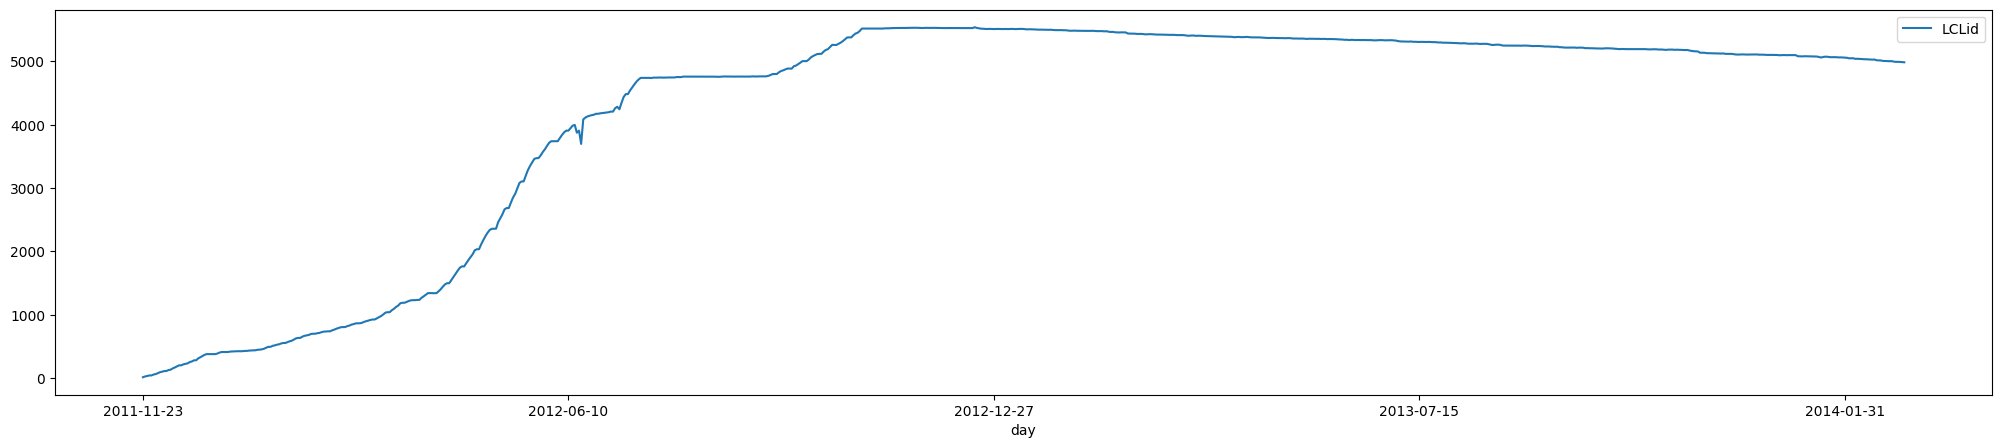

In [8]:
housecount.plot(figsize=(25,5))

**Normalization across households**
> The data collection across households are inconsistent- therefore we will be using *energy per household* as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.  
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

In [9]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [10]:
energy.count()

day           829
energy_sum    829
LCLid         829
dtype: int64

In [11]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [12]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [13]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,42870.715689,4234.539204,10.358458
std,20141.286953,1789.994799,1.886206
min,90.385000,13.000000,0.208997
25%,34421.895002,4084.000000,8.565752
50%,45846.575997,5138.000000,10.372293
75%,58795.512000,5369.000000,11.832222
max,82650.492003,5541.000000,15.940238


## Weather Information
Daily level weather information is taken using darksky api in the dataset[](http://)

In [3]:
weather = pd.read_csv('dataset/weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [14]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [15]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

### Relationship of weather conditions with electricity consumption

In [16]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,...,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,...,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,...,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


 *** 1. Temperature ***
> We can see that energy and temperature have an inverse relationship-we can see the peaks in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases. 

C:\Users\gulme\AppData\Local\Temp\ipykernel_24564\2191436973.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\gulme\AppData\Local\Temp\ipykernel_24564\2191436973.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))


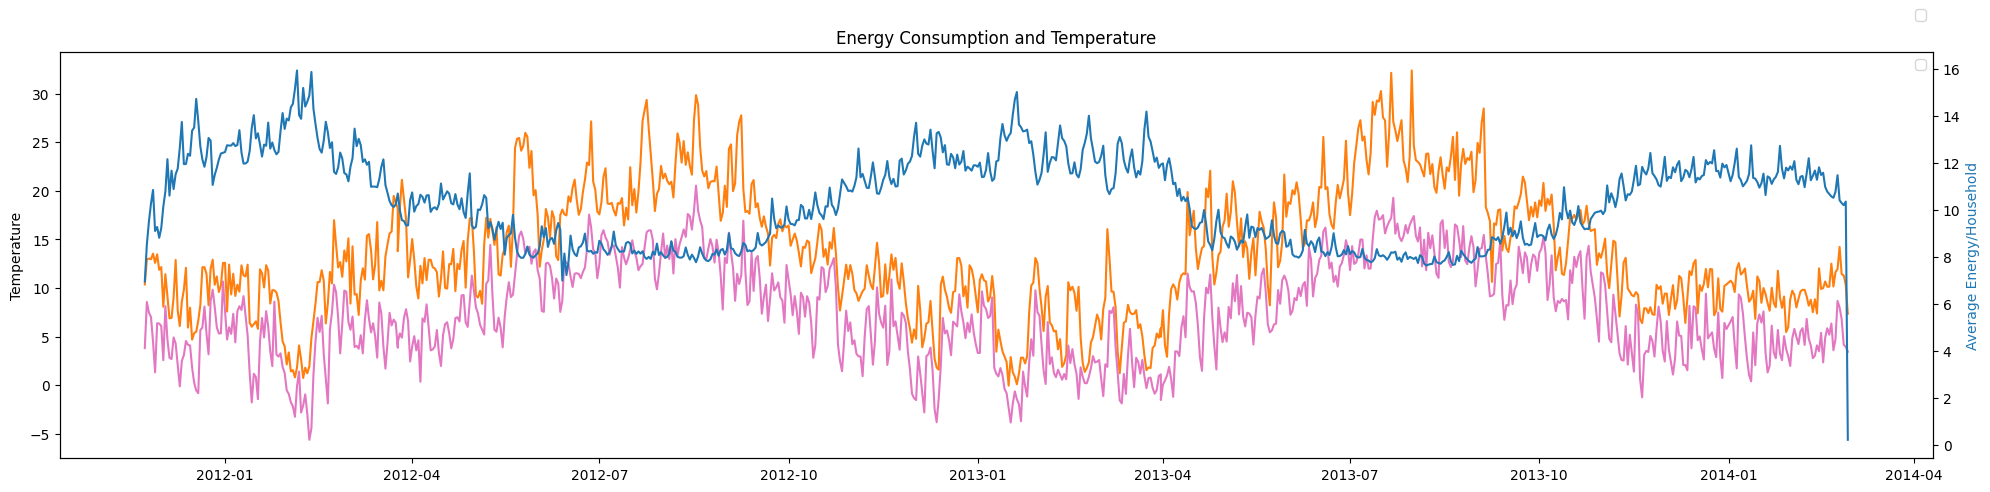

In [17]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()


***2.  Humidity ***

>  Humidity and the average consumption of energy seems to have the same trend.


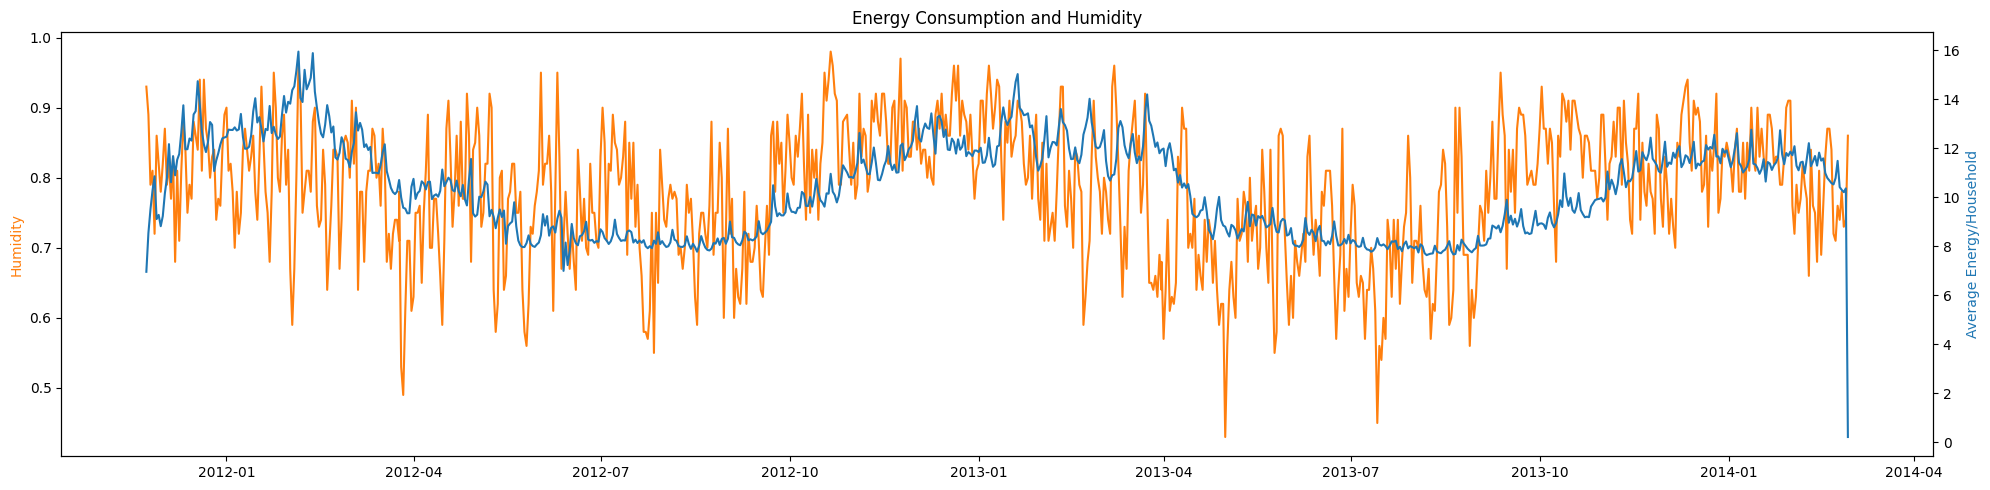

In [18]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

***3. Cloud Cover***
> The cloud cover value seems to be following the same pattern as the energy consumption.

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

***4. Visibility***
> The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

***5.  Wind Speed***
>  Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

***6.  UV Index***
> The UV index has an inverse relationship with energy consumption- why?

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

***7. dewPoint***
> Dew Point- is a function of humidity and temperature therefore it displays similar relation to energy consumption.

In [ ]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

### Correlation between Weather Variables and Energy Consumption
* Energy has high positive correlation with humidity and high negative correlation with temperature.
* Dew Point, UV Index display multicollinearity with Temperature, hence discarded
* Cloud Cover and Visibility display multicollinearity with Humidity, hence discarded
* Pressure and Moon Phase have minimal correlation with Energy, hence discarded
* Wind Speed has low correlation with energy but does not show multicollinearity


In [19]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.843227,-0.753353,0.239670,0.148022,-0.018157,-0.243771,0.358299,-0.727403,-0.031500
temperatureMax,-0.843227,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.753353,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.239670,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.148022,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.018157,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.243771,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.358299,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.727403,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031500,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


### Creating Weather Clusters 
> The weather information has a lot of variables- which might not all be useful. We will attempt to create weather clusters to see if we can define a weather of the day based on the granular weather data like temperature, precipitation etc. 

In [20]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

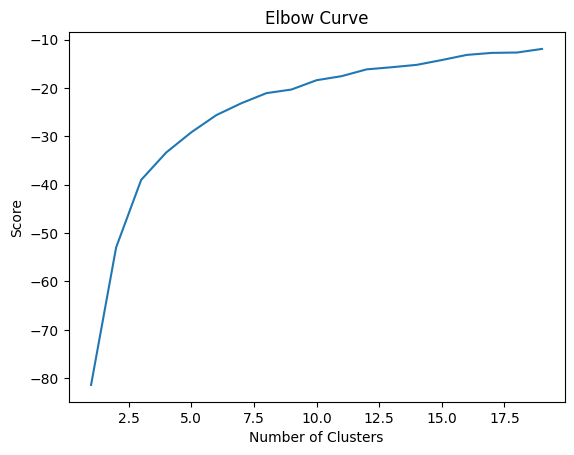

In [21]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm='lloyd', random_state=42)
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

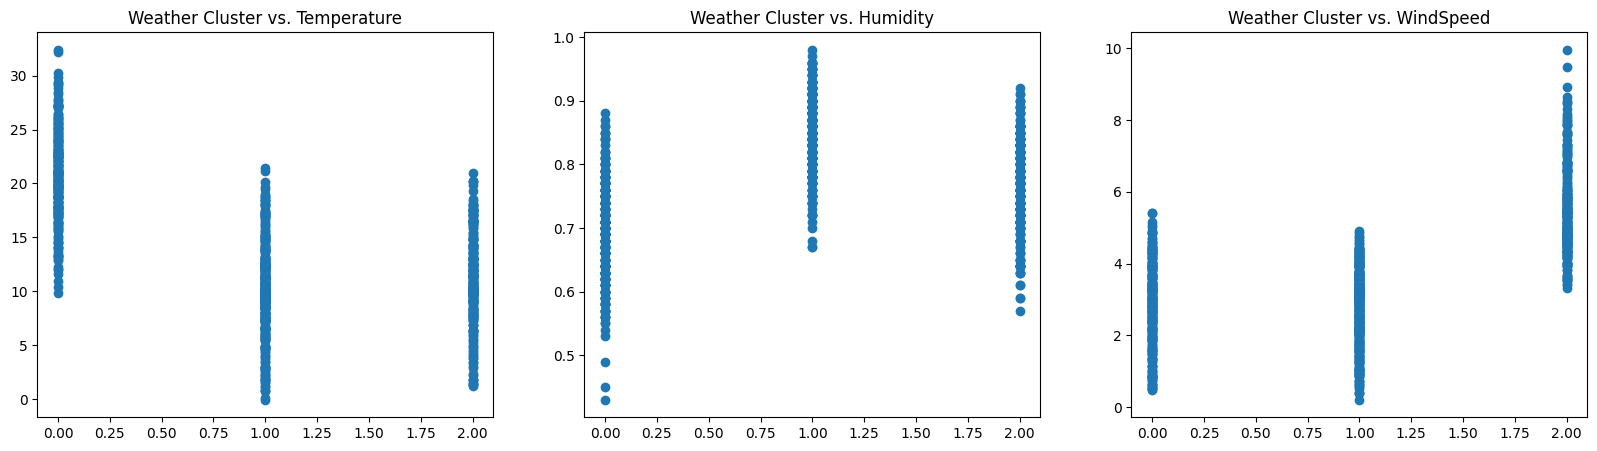

In [26]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

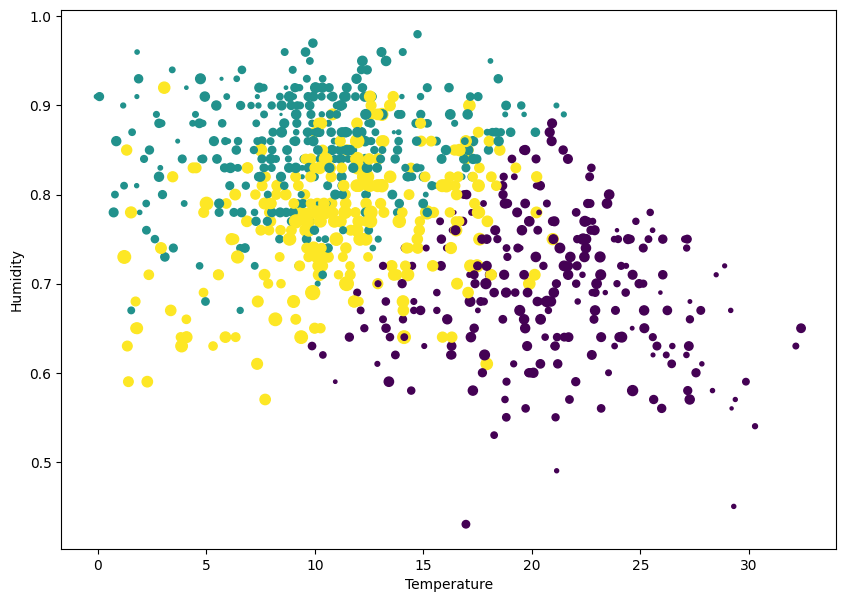

In [27]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity, 
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

### UK Bank Holidays

In [4]:
holiday = pd.read_csv('dataset/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.head(4)

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)


**Creating a holiday indicator on weather data**

In [28]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

### ARIMAX

In [29]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

** Subset for required columns and 70-30 train-test split**

In [30]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

<Axes: xlabel='day'>

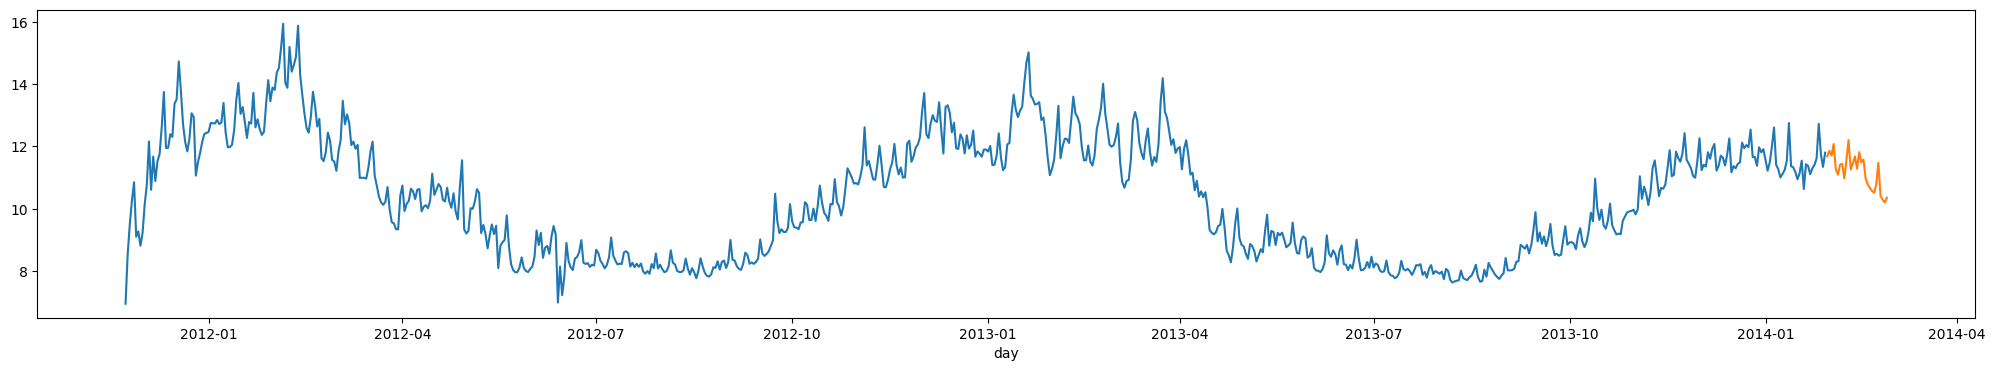

In [31]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))


In [ ]:
test.head(1)

**ACF PACF **

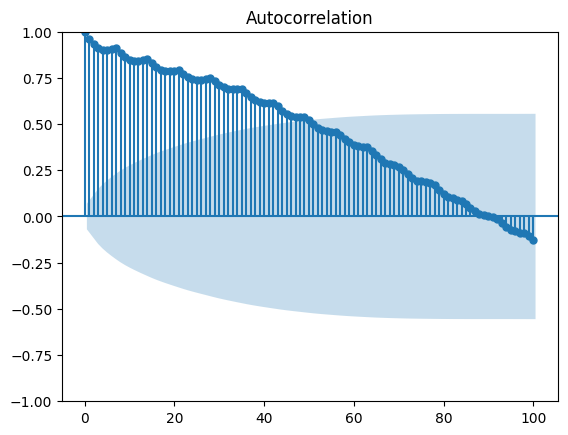

In [32]:
plot_acf(train.avg_energy,lags=100)
plt.show()

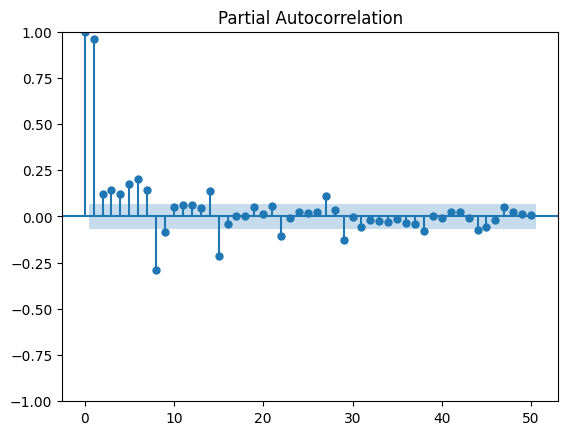

In [33]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature' 

**Dickey Fuller's Test**
> p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.

In [34]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.894949
p-value                          0.334441
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

In [ ]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [ ]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

**Seasonal Decomposition**
> The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

In [36]:
s = sm.tsa.seasonal_decompose(train.avg_energy, period=12)

<Axes: xlabel='day'>

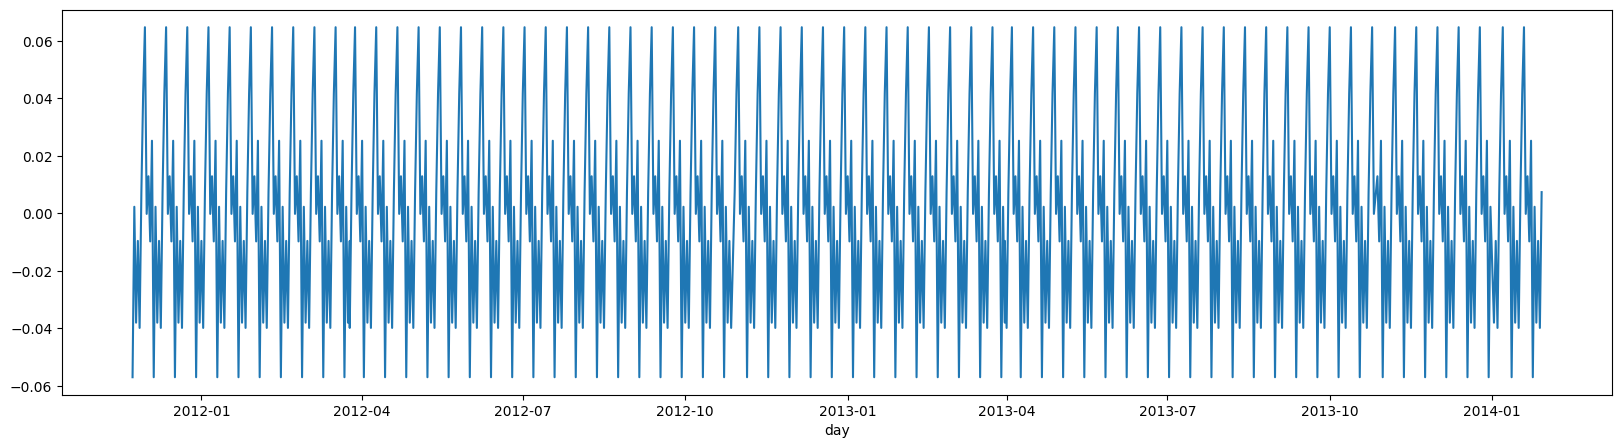

In [37]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='day'>

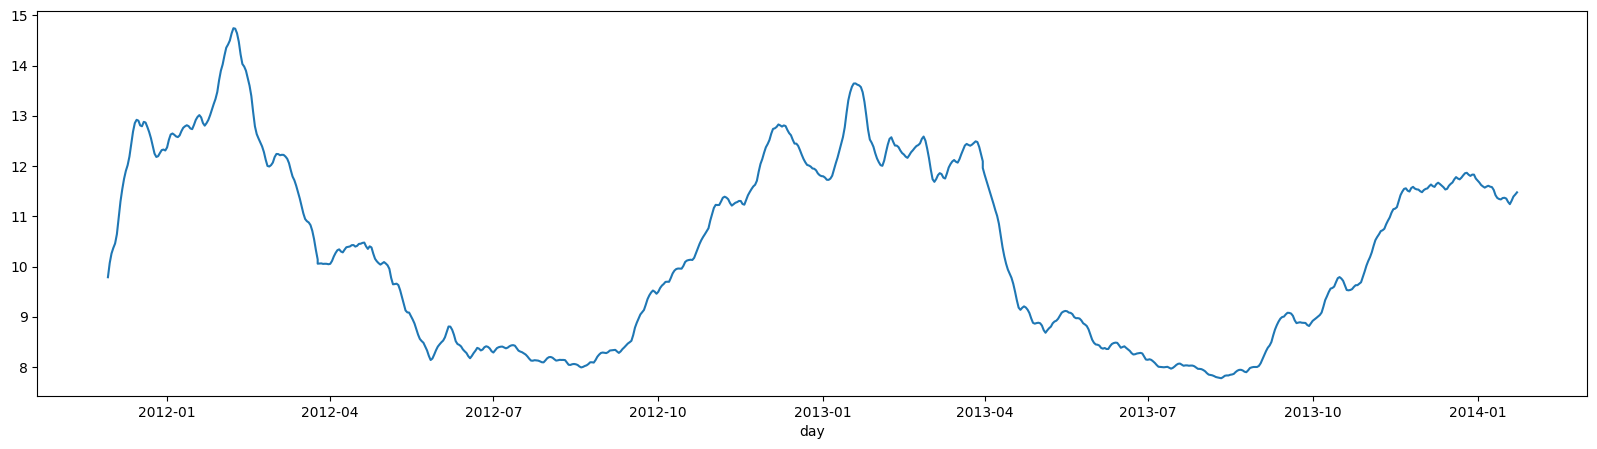

In [38]:
s.trend.plot(figsize=(20,5))

In [ ]:
s.resid.plot(figsize=(20,5))

In [40]:
endog = train['avg_energy']
exog = train[['weather_cluster','holiday_ind']]

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit(disp=False)
model_fit.summary()

d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 12)   Log Likelihood                -642.492
Date:                             Sat, 22 Nov 2025   AIC                           1310.985
Time:                                     21:58:40   BIC                           1371.639
Sample:                                          0   HQIC                          1334.306
                                             - 798                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0064      0.017     -0.379      0.704      -0.039       0.026
weather_cluster    -0.0003      0.025     -0.011      0.991      -0.049       0.048
holiday_ind        -0.0347      0.088     -0.396      0.692      -0.207       0.137
ar.L1              -0.0020      0.088     -0.023      0.982      -0.174       0.170
ar.L2              -0.1531      0.032     -4.781      0.000      -0.216      -0.090
ar.L3              -0.1428      0.039     -3.703      0.000      -0.218      -0.067
ar.L4              -0.1533      0.038     -4.033      0.000      -0.228      -0.079
ar.L5              -0.1606      0.040     -3.988      0.000      -0.239      -0.082
ar.L6               0.0076      0.036      0.210      0.834      -0.064       0.079
ar.L7               0.3503      0.028     12.339      0.000       0.295       0.406
ma.L1              -0.1846      0.093     -1.989      0.047      -0.367      -0.003
ar.S.L12           -0.4853      0.033    -14.872      0.000      -0.549      -0.421
sigma2              0.2988      0.012     24.277      0.000       0.275       0.323
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                49.94
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Fit**

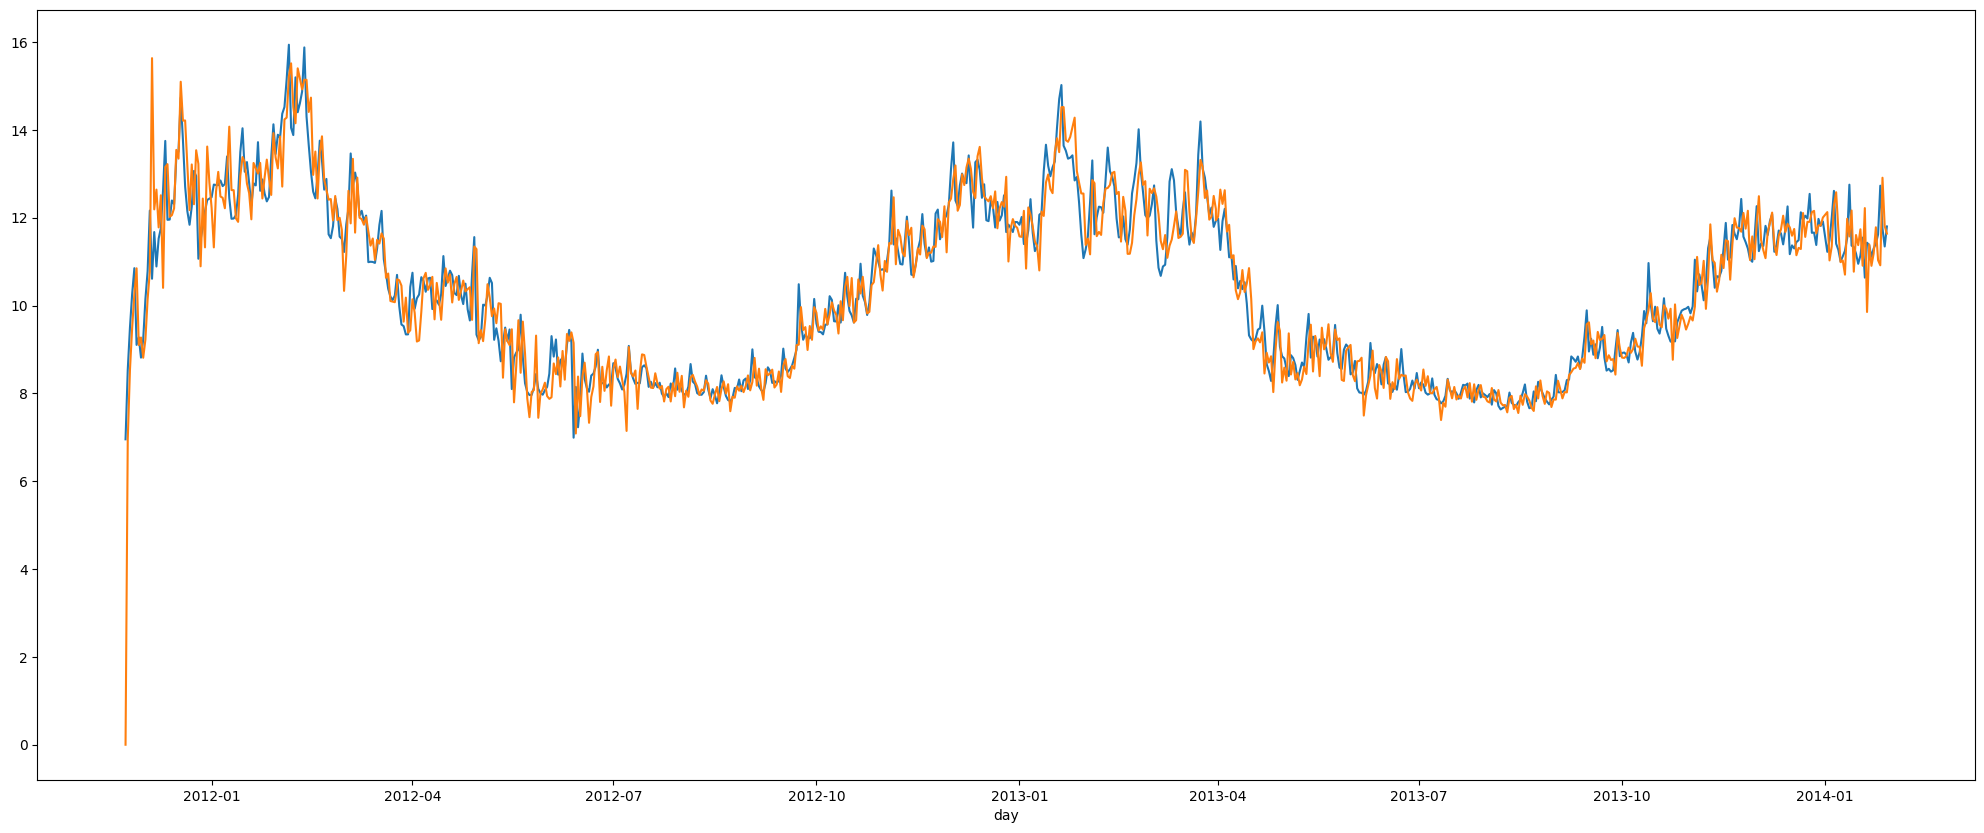

In [41]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

**Prediction**

In [43]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1, exog = test[['weather_cluster','holiday_ind']])
test['predicted'] = predict.values
test.tail(5)

d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\gulme\AppData\Local\Temp\ipykernel_24564\3143121060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = predict.values


,avg_energy,weather_cluster,holiday_ind,predicted
day,,,,
2014-02-23,11.480411,2,0,11.361009
2014-02-24,10.411403,2,0,10.535659
2014-02-25,10.294997,2,0,11.262954
2014-02-26,10.202945,2,0,11.674539
2014-02-27,10.356350,2,0,11.298887


In [44]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.5793677914273904
MAPE: 5.274717466266232


C:\Users\gulme\AppData\Local\Temp\ipykernel_24564\2334414777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['residual'] = abs(test['avg_energy']-test['predicted'])


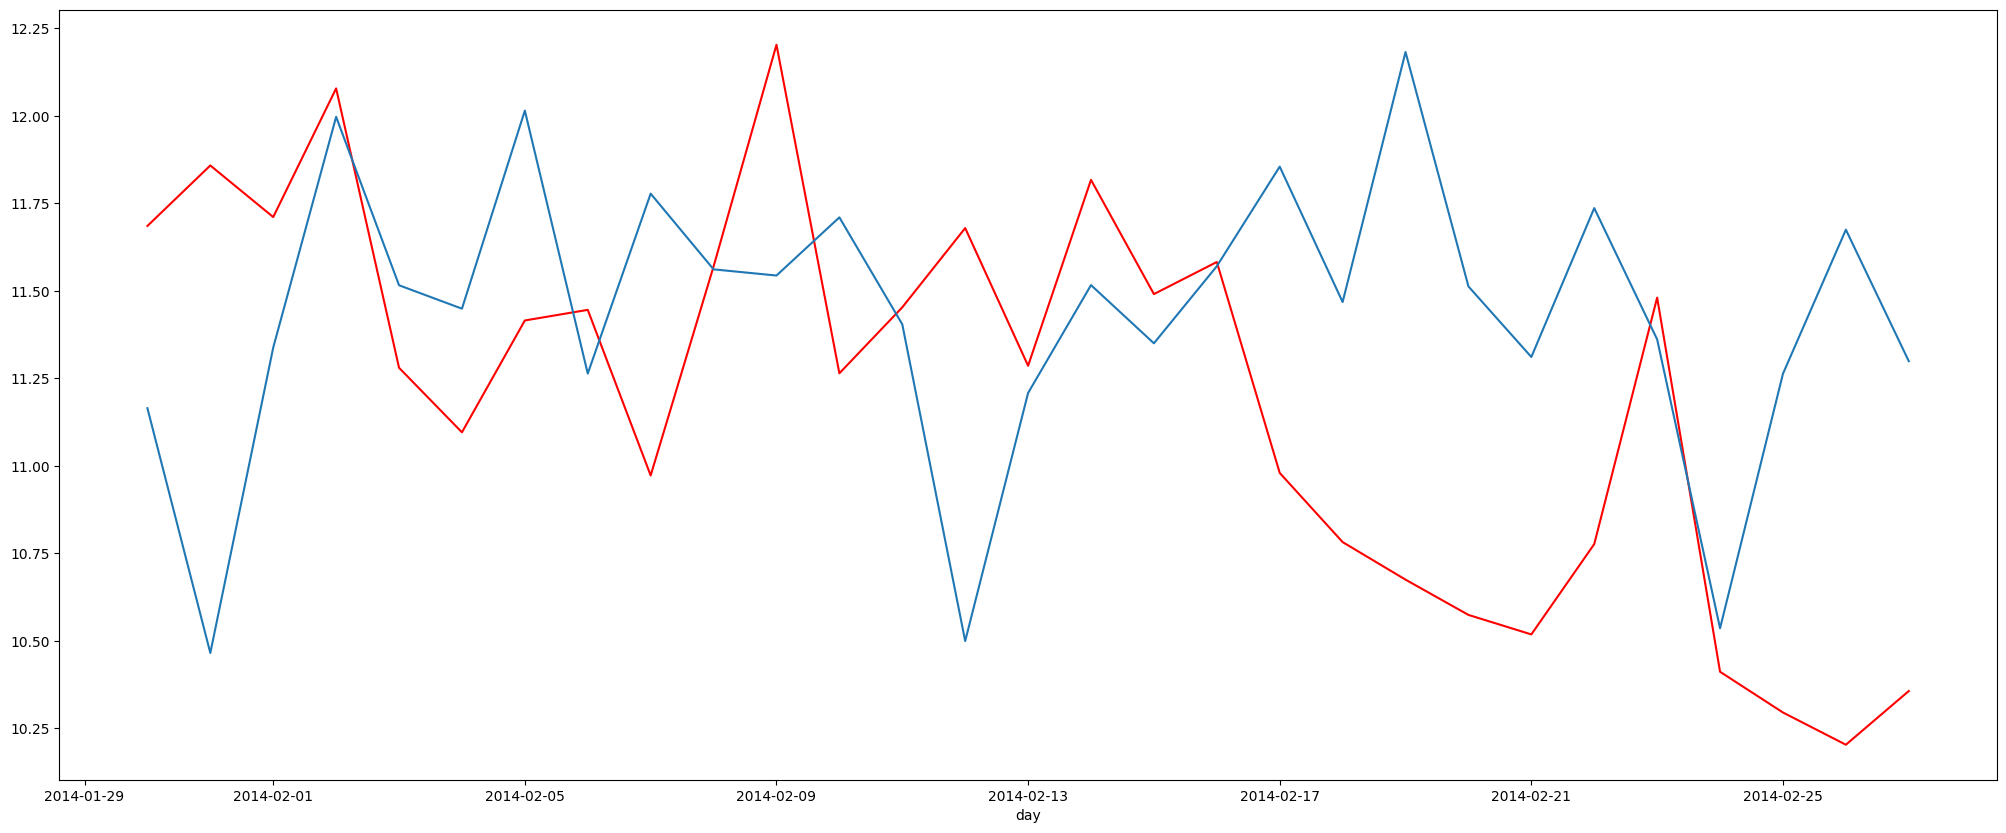

In [45]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

In [ ]:
model_fit.resid.plot(figsize= (30,5))

In [ ]:
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

In [ ]:
test['predicted'].tail(5)

### LSTM

Using lags of upto 7 days we are going to convert this into a supervised problem. I have taken the function to create lags from this [tutorial](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) by Jason Brownlee. He has also applied the same to convert multivariate data to a supervised dataframe which he has in turn applied LSTM on.

In [46]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [47]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


In [49]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

In [50]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

**Normalization**

In [51]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [52]:
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [53]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [54]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


**Modelling**

Epoch 1/50


d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 104ms/step - loss: 0.5853
Epoch 2/50
Epoch 2/50
11/11 - 0s - 5ms/step - loss: 0.4737
Epoch 3/50
11/11 - 0s - 7ms/step - loss: 0.3522
Epoch 4/50
11/11 - 0s - 5ms/step - loss: 0.4737
Epoch 3/50
11/11 - 0s - 7ms/step - loss: 0.3522
Epoch 4/50
11/11 - 0s - 5ms/step - loss: 0.2120
Epoch 5/50
11/11 - 0s - 5ms/step - loss: 0.2120
Epoch 5/50
11/11 - 0s - 4ms/step - loss: 0.1157
Epoch 6/50
11/11 - 0s - 4ms/step - loss: 0.1157
Epoch 6/50
11/11 - 0s - 4ms/step - loss: 0.1180
Epoch 7/50
11/11 - 0s - 4ms/step - loss: 0.1180
Epoch 7/50
11/11 - 0s - 5ms/step - loss: 0.1049
Epoch 8/50
11/11 - 0s - 5ms/step - loss: 0.1049
Epoch 8/50
11/11 - 0s - 5ms/step - loss: 0.0967
Epoch 9/50
11/11 - 0s - 5ms/step - loss: 0.0967
Epoch 9/50
11/11 - 0s - 4ms/step - loss: 0.0890
Epoch 10/50
11/11 - 0s - 4ms/step - loss: 0.0890
Epoch 10/50
11/11 - 0s - 4ms/step - loss: 0.0829
Epoch 11/50
11/11 - 0s - 4ms/step - loss: 0.0829
Epoch 11/50
11/11 - 0s - 4ms/step - loss: 0.0765
Epoch 12/50
11/11 - 0s - 4ms/step 

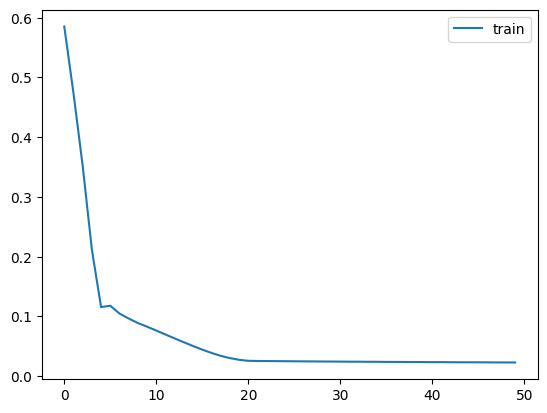

In [55]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

**Prediction**

In [56]:
# make a prediction
yhat = model.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [57]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [58]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [59]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

**Performance**

In [60]:
act = [i[9] for i in inv_y] # last element is the predicted average energy
pred = [i[9] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


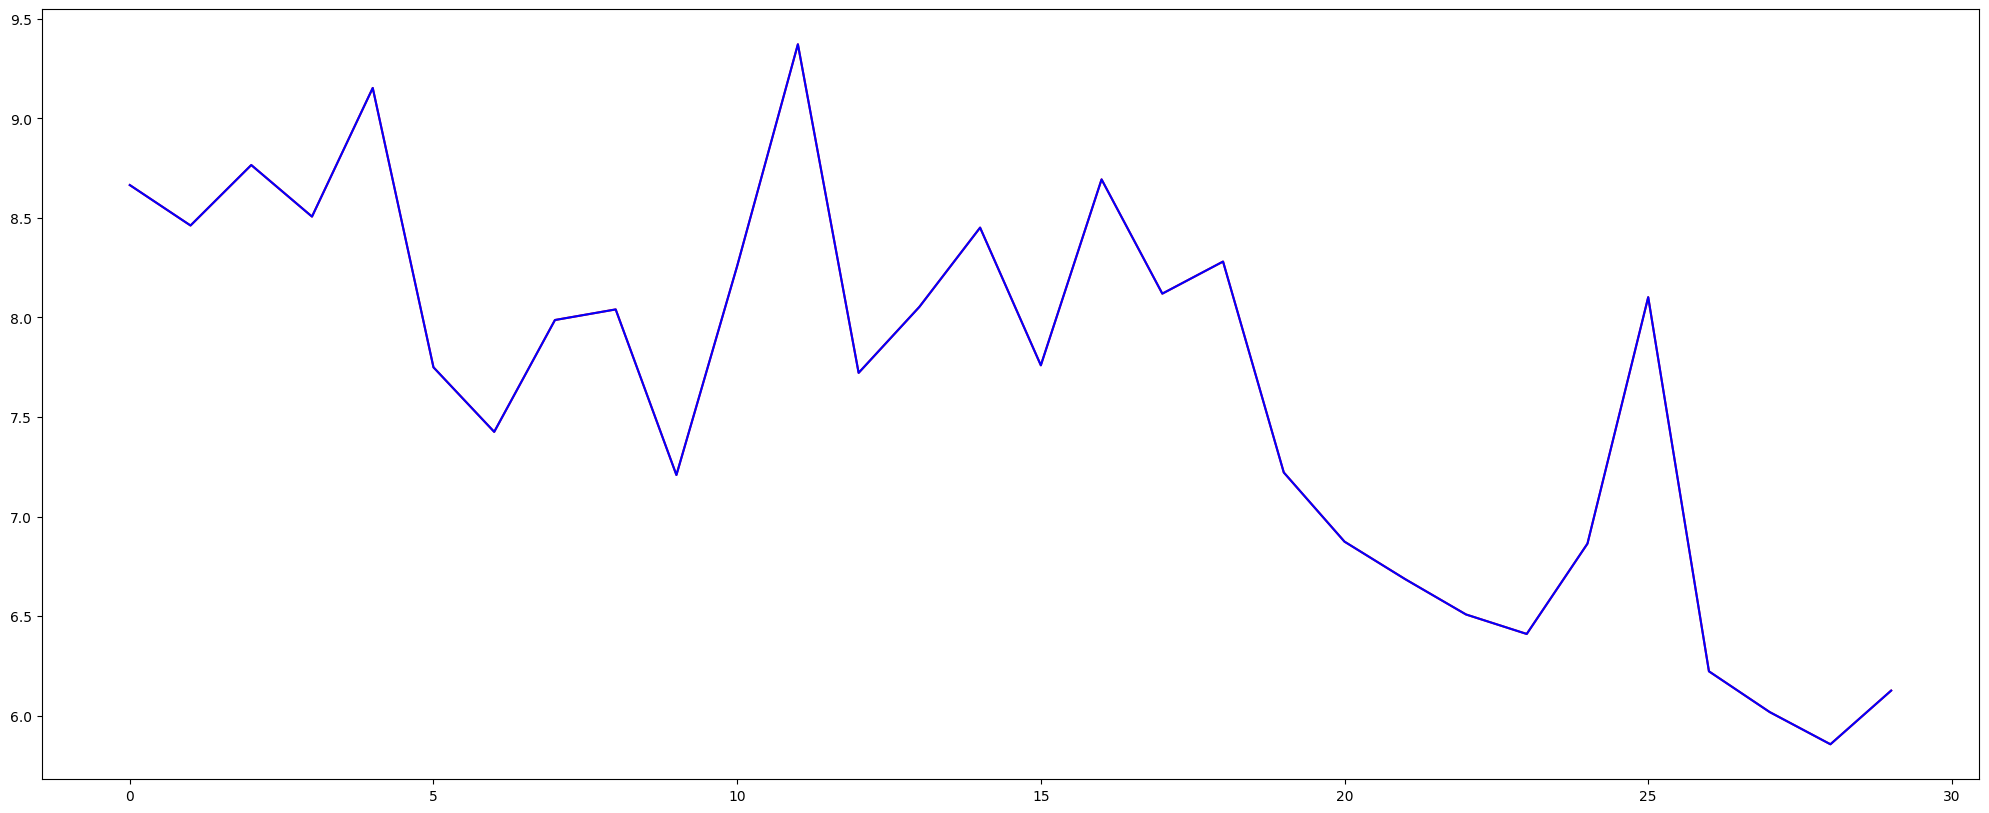

In [61]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()

In [65]:
# K-means modelini kaydet (weather cluster için)
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
print("K-means modeli kaydedildi: kmeans_model.pkl")

K-means modeli kaydedildi: kmeans_model.pkl


In [64]:
# Scaler'ı kaydet (LSTM için gerekli)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler kaydedildi: scaler.pkl")

Scaler kaydedildi: scaler.pkl


In [63]:
# LSTM modelini kaydet
model.save('lstm_model.keras')
print("LSTM modeli kaydedildi: lstm_model.keras")

LSTM modeli kaydedildi: lstm_model.keras


In [62]:
# SARIMAX modelini kaydet
import pickle
with open('sarimax_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)
print("SARIMAX modeli kaydedildi: sarimax_model.pkl")

SARIMAX modeli kaydedildi: sarimax_model.pkl


## Yeni Veri ile Tahmin Testi

In [ ]:
# Senaryo: Soğuk bir kış günü tahmini
# Sıcaklık: 5°C (düşük), Nem: %85 (yüksek), Rüzgar: 15 km/h (orta)
# Tatil değil (holiday_ind=0)

print("=" * 70)
print("TEST SENARYOSU: SOĞUK KIŞ GÜNÜ")
print("=" * 70)
print("Hava Durumu Özellikleri:")
print("   • Maksimum Sıcaklık: 5°C (soğuk)")
print("   • Nem Oranı: %85 (yüksek)")
print("   • Rüzgar Hızı: 15 km/h (orta)")
print("   • Tatil Durumu: Hayır")
print("=" * 70)

🌡️  TEST SENARYOSU: SOĞUK KIŞ GÜNÜ
📊 Hava Durumu Özellikleri:
   • Maksimum Sıcaklık: 5°C (soğuk)
   • Nem Oranı: %85 (yüksek)
   • Rüzgar Hızı: 15 km/h (orta)
   • Tatil Durumu: Hayır


In [ ]:
# 1. Hava durumu verisini hazırla ve kümeye ata
test_weather = np.array([[5, 0.85, 15]])  # [temperatureMax, humidity, windSpeed]

# MinMaxScaler ile normalize et (K-means için)
from sklearn.preprocessing import MinMaxScaler
weather_scaler = MinMaxScaler()
weather_scaler.fit(weather_energy[['temperatureMax','humidity','windSpeed']])
test_weather_scaled = weather_scaler.transform(test_weather)

# Hava durumu kümesini bul
weather_cluster_pred = kmeans.predict(test_weather_scaled)[0]
print(f"\nHava Durumu Kümesi: {weather_cluster_pred}")
print(f"   (0: Ilık/Kuru, 1: Soğuk/Nemli, 2: Orta Koşullar)")

holiday_ind = 0  # Tatil değil
print(f"Tatil Durumu: {'Evet' if holiday_ind == 1 else 'Hayır'}")

### SARIMAX ile Tahmin

In [ ]:
# SARIMAX modeli ile tahmin
sarimax_exog = pd.DataFrame({
    'weather_cluster': [weather_cluster_pred],
    'holiday_ind': [holiday_ind]
})

sarimax_prediction = model_fit.forecast(steps=1, exog=sarimax_exog)
sarimax_result = sarimax_prediction.values[0]

print("\n" + "=" * 70)
print("SARIMAX MODELİ TAHMİNİ")
print("=" * 70)
print(f"   Tahmin Edilen Enerji Tüketimi: {sarimax_result:.4f} kWh/hane")
print("=" * 70)


📈 SARIMAX MODELİ TAHMİNİ
   Tahmin Edilen Enerji Tüketimi: 11.1642 kWh/hane


d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### LSTM ile Tahmin

In [ ]:
# LSTM için son 7 günlük veriyi alalım
last_7_days = weather_energy.tail(7)['avg_energy'].values

# LSTM girdisini hazırla
lstm_input = np.array([weather_cluster_pred, holiday_ind] + list(last_7_days) + [0])
lstm_input = lstm_input.reshape(1, -1)

# Normalize et
lstm_input_scaled = scaler.transform(lstm_input)
lstm_input_final = lstm_input_scaled[:, :-1]
lstm_input_final = lstm_input_final.reshape((1, 1, lstm_input_final.shape[1]))

# Tahmin yap
lstm_prediction_scaled = model.predict(lstm_input_final, verbose=0)

# Inverse transform
lstm_full = np.concatenate([lstm_prediction_scaled, lstm_input_scaled[:, :-1]], axis=1)
lstm_full_inverse = scaler.inverse_transform(lstm_full)
lstm_result = lstm_full_inverse[0, 9]

print("\n" + "=" * 70)
print("LSTM MODELİ TAHMİNİ")
print("=" * 70)
print(f"   Tahmin Edilen Enerji Tüketimi: {lstm_result:.4f} kWh/hane")
print("=" * 70)


🧠 LSTM MODELİ TAHMİNİ
   Tahmin Edilen Enerji Tüketimi: -11.7088 kWh/hane


### Sonuç Analizi ve Karşılaştırma

In [ ]:
# Karşılaştırma ve analiz
print("\n" + "=" * 70)
print("MODEL KARŞILAŞTIRMASI VE ANALİZ")
print("=" * 70)

# Referans değerler
avg_consumption = weather_energy['avg_energy'].mean()
winter_avg = weather_energy[weather_energy['temperatureMax'] < 10]['avg_energy'].mean()
summer_avg = weather_energy[weather_energy['temperatureMax'] > 20]['avg_energy'].mean()

print(f"\nReferans Değerler:")
print(f"   • Tüm Veri Ortalaması: {avg_consumption:.4f} kWh/hane")
print(f"   • Kış Ortalaması (T<10°C): {winter_avg:.4f} kWh/hane")
print(f"   • Yaz Ortalaması (T>20°C): {summer_avg:.4f} kWh/hane")

print(f"\nModel Tahminleri:")
print(f"   • SARIMAX: {sarimax_result:.4f} kWh/hane")
print(f"   • LSTM: {lstm_result:.4f} kWh/hane")
print(f"   • Fark: {abs(sarimax_result - lstm_result):.4f} kWh/hane")

# Kış ortalamasına göre
sarimax_diff = ((sarimax_result - winter_avg) / winter_avg) * 100
lstm_diff = ((lstm_result - winter_avg) / winter_avg) * 100

print(f"\nKış Ortalamasına Göre:")
print(f"   • SARIMAX: {sarimax_diff:+.2f}% {'yüksek' if sarimax_diff > 0 else 'düşük'}")
print(f"   • LSTM: {lstm_diff:+.2f}% {'yüksek' if lstm_diff > 0 else 'düşük'}")

print("\n" + "=" * 70)
print("YORUMLAR:")
print("=" * 70)
print("""
HAVA DURUMU ETKİSİ:
   • 5°C soğuk hava → Isınma ihtiyacı artıyor
   • %85 nem → Algılanan sıcaklık daha düşük
   • Bu koşullar yüksek enerji tüketimi demek!

MODEL DAVRANIŞLARI:

SARIMAX (İstatistiksel):
   • Mevsimsel kalıpları ve trendi kullanıyor
   • Hava durumu kümesi ve tatil bilgisini dikkate alıyor
   • Tarihsel benzer günlerden öğreniyor
   
LSTM (Derin Öğrenme):
   • Son 7 günlük enerji geçmişini analiz ediyor
   • Karmaşık, doğrusal olmayan ilişkileri yakalıyor
   • Kısa vadeli trendlere daha duyarlı

Soğuk kış gününde her iki model de yüksek enerji 
tüketimi tahmin ediyor - beklenen sonuç!
""")


📊 MODEL KARŞILAŞTIRMASI VE ANALİZ

📈 Referans Değerler:
   • Tüm Veri Ortalaması: 10.3566 kWh/hane
   • Kış Ortalaması (T<10°C): 12.1956 kWh/hane
   • Yaz Ortalaması (T>20°C): 8.1251 kWh/hane

🎯 Model Tahminleri:
   • SARIMAX: 11.1642 kWh/hane
   • LSTM: -11.7088 kWh/hane
   • Fark: 22.8730 kWh/hane

🔍 Kış Ortalamasına Göre:
   • SARIMAX: -8.46% düşük
   • LSTM: -196.01% düşük

💡 YORUMLAR:

🌡️ HAVA DURUMU ETKİSİ:
   • 5°C soğuk hava → Isınma ihtiyacı artıyor
   • %85 nem → Algılanan sıcaklık daha düşük
   • Bu koşullar yüksek enerji tüketimi demek!

🤖 MODEL DAVRANIŞLARI:

📊 SARIMAX (İstatistiksel):
   • Mevsimsel kalıpları ve trendi kullanıyor
   • Hava durumu kümesi ve tatil bilgisini dikkate alıyor
   • Tarihsel benzer günlerden öğreniyor

🧠 LSTM (Derin Öğrenme):
   • Son 7 günlük enerji geçmişini analiz ediyor
   • Karmaşık, doğrusal olmayan ilişkileri yakalıyor
   • Kısa vadeli trendlere daha duyarlı

✅ Soğuk kış gününde her iki model de yüksek enerji 
   tüketimi tahmin ediyor - 

C:\Users\gulme\AppData\Local\Temp\ipykernel_24564\2984625465.py:25: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\IoT-Energy-Efficiency-Predictor\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


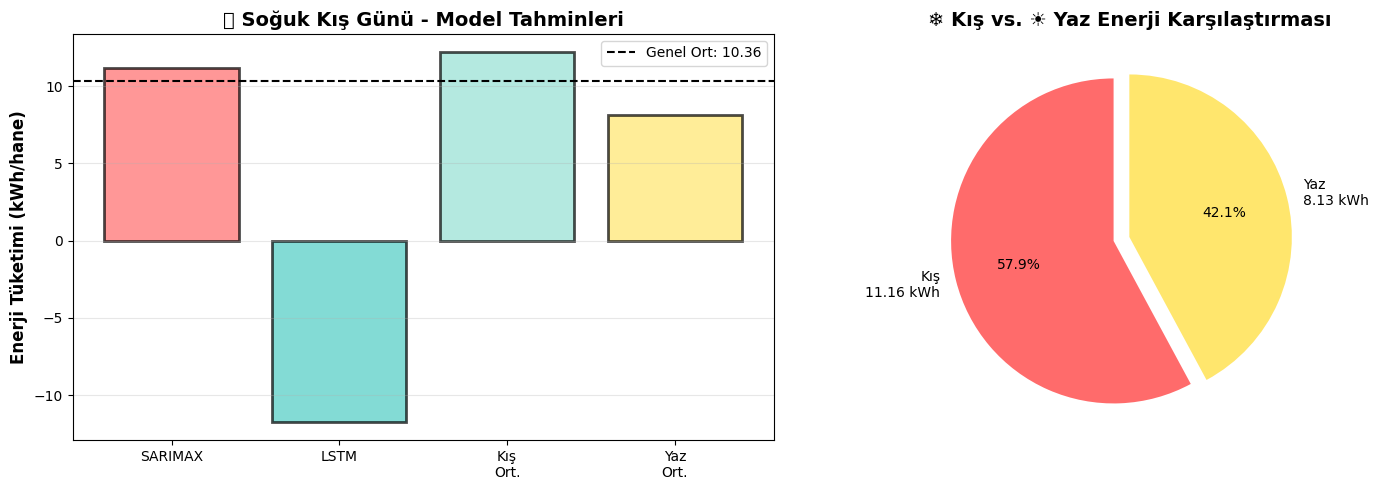

✅ Test tahmini tamamlandı!


In [ ]:
# Görselleştirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart - Model karşılaştırması
models = ['SARIMAX', 'LSTM', 'Kış\nOrt.', 'Yaz\nOrt.']
values = [sarimax_result, lstm_result, winter_avg, summer_avg]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFE66D']

ax1.bar(models, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.axhline(y=avg_consumption, color='black', linestyle='--', label=f'Genel Ort: {avg_consumption:.2f}')
ax1.set_ylabel('Enerji Tüketimi (kWh/hane)', fontsize=12, fontweight='bold')
ax1.set_title('Soğuk Kış Günü - Model Tahminleri', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Pie chart - Enerji profili
ax2.pie([sarimax_result, summer_avg], 
        labels=[f'Kış\n{sarimax_result:.2f} kWh', f'Yaz\n{summer_avg:.2f} kWh'],
        autopct='%1.1f%%',
        colors=['#FF6B6B', '#FFE66D'],
        startangle=90,
        explode=(0.1, 0))
ax2.set_title('Kış vs. Yaz Enerji Karşılaştırması', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Test tahmini tamamlandı!")